### Initialize Data

In [1]:
import torch
import torch.optim as optim
from torchvision import transforms
from mock_dataset import MockOutfitDataset
from outfit_model import OutfitCompatibilityModel
from outfit_dataset import OutfitDataset
import torch.nn as nn
from utils import save_checkpoint
import logging

# DEBUG - INFO - WARNING - ERROR
logging.basicConfig(level=logging.WARNING)
data_dir = "data"

# Should be disjoint/nondisjoint
polyvore_split = "nondisjoint"

# Should be traim/valid/test
split_valid = "valid"
split_train = "train"
split_test = "test"

default_batch_size = 25

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ]
)


# Organizes your dataset into batches. If we don't do this, our texts matrix will be transposed
# Batch size = number of samples processed in one iteration
# Number of batches = total samples divided by batch_size
# Each this case, a sample = an outfit
def custom_collate(batch):
    outfits_images = []
    outfits_texts = []
    outfits_labels = []

    # Find the maximum number of items in any outfit in this batch
    max_items = max(len(outfit["outfit_images"]) for outfit in batch)

    for outfit in batch:
        # Pad or truncate the number of items to match max_items
        padded_images = torch.zeros((max_items,) + outfit["outfit_images"].shape[1:])
        padded_images[: outfit["outfit_images"].shape[0]] = outfit["outfit_images"]

        # Similarly, pad or truncate the number of texts
        padded_texts = outfit["outfit_texts"] + [""] * (
            max_items - len(outfit["outfit_texts"])
        )

        outfits_images.append(padded_images)
        outfits_texts.append(padded_texts)
        outfits_labels.append(outfit["outfit_label"])

    return {
        "outfit_images": torch.stack(outfits_images),
        "outfit_texts": outfits_texts,
        "outfit_labels": torch.tensor(outfits_labels, dtype=torch.float),
    }


train_dataset = OutfitDataset(data_dir, polyvore_split, split_train, transform)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=default_batch_size,
    shuffle=True,
    collate_fn=custom_collate,
)

valid_dataset = OutfitDataset(data_dir, polyvore_split, split_valid, transform)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=default_batch_size,
    shuffle=True,
    collate_fn=custom_collate,
)

total_train_num_outfits = len(train_dataloader.dataset)
total_valid_num_outfits = len(valid_dataloader.dataset)

print(
    f"total_num_outfits of splits:{split_train}: {total_train_num_outfits}; {split_valid}: {total_valid_num_outfits}"
)

# Instantiate the mock dataset and dataloader
# Contains list of all outfits
# mock_dataset = MockOutfitDataset()

# dataloader = torch.utils.data.DataLoader(
#     mock_dataset, batch_size=15, shuffle=True, collate_fn=custom_collate
# )

total_num_outfits of splits:train: 50; valid: 50


### Visualize Data

In [2]:
# CURRENTLY NOT USABLE

# from matplotlib import pyplot as plt
# import torchvision.transforms.functional as F


# def show_images(images, labels):
#     for i in range(images.size(1)):
#         image = F.to_pil_image(images[:, i, ...])
#         plt.subplot(1, images.size(1), i + 1)
#         plt.imshow(image)
#         plt.title(f"Label: {labels[i]}")
#         plt.axis("off")
#     plt.show()


# for batch_idx, (images, texts, labels) in enumerate(dataloader):
#     print(
#         f"Batch {batch_idx + 1} - Shape of images: {images.shape}, Texts: {texts}, Labels: {labels}"
#     )

#     # Visualize the images
#     show_images(images, labels)
    
#     if batch_idx == 2:  # Print information for the first 3 batches
#         break

### Init Model

In [3]:
# Instantiate the model and components for training (loss function, optimizer)
model = OutfitCompatibilityModel()
focal_loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


c:\Users\phamm\.conda\envs\outfit_recommendation\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\phamm\.conda\envs\outfit_recommendation\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\phamm\.conda\envs\outfit_recommendation\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_t

### Training

In [4]:
# Training loop
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score


def show_plots(plots, label):
    for plot in plots:
        plt.plot(plot["values"], label=plot["label"])

    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.show()


def test(epoch, dataloader, losses, auc_scores):
    model.eval()
    all_val_labels = []
    all_val_outputs = []

    with torch.no_grad():
        for val_batch in dataloader:
            val_images = val_batch["outfit_images"]
            val_texts = val_batch["outfit_texts"]
            val_labels = val_batch["outfit_labels"]

            val_outputs = model(val_images, val_texts)
            val_loss = focal_loss(val_outputs, val_labels)

            all_val_labels.extend(val_labels.cpu().numpy())
            all_val_outputs.extend(val_outputs.cpu().numpy())

    losses.append(val_loss.item() / len(dataloader))

    # Calculate AUC score
    auc = roc_auc_score(all_val_labels, all_val_outputs)
    auc_scores.append(auc)
    print(f"Epoch {epoch + 1}, AUC: {auc}")

Epoch 1, AUC: 0.3940972222222222
Epoch 2, AUC: 0.546875
Epoch 3, AUC: 0.4809027777777778
Epoch 4, AUC: 0.5190972222222222
Epoch 5, AUC: 0.4409722222222222


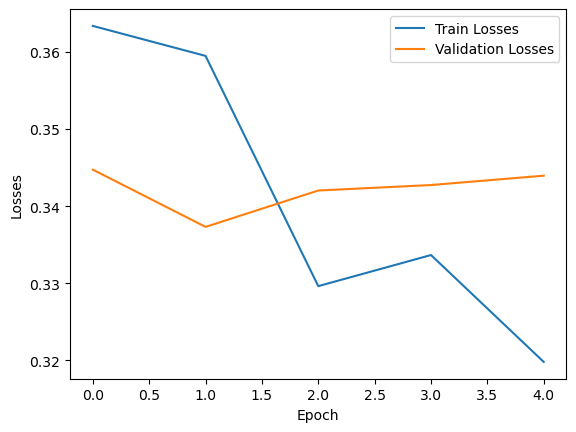

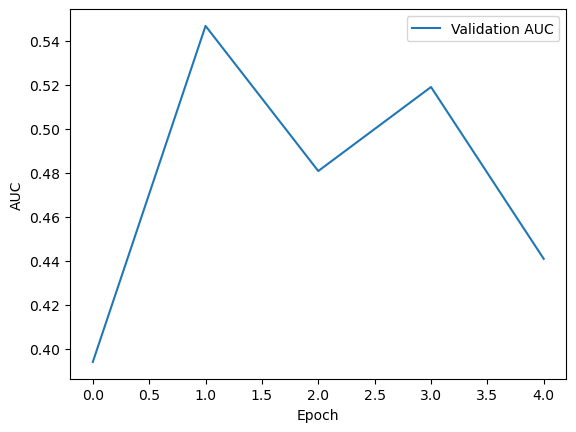

In [5]:

num_epochs = 5
train_losses = []  # to store training losses
val_losses = []  # to store validation losses
val_auc_scores = []  # to store AUC scores

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    for batch in train_dataloader:
        images = batch["outfit_images"]
        texts = batch["outfit_texts"]
        labels = batch["outfit_labels"]

        logging.debug(f"batch - images.shape: {images.shape}")
        logging.debug(f"batch - texts: {texts}")
        logging.debug(f"batch - labels: {labels}")

        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = focal_loss(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print the average loss for the epoch
    train_losses.append(loss.item() / len(train_dataloader))

    # region Validation Phase
    test(
        epoch=epoch,
        dataloader=valid_dataloader,
        losses=val_losses,
        auc_scores=val_auc_scores,
    )

    # endregion

    save_checkpoint(model.state_dict(), polyvore_split, f"model_epoch_{epoch + 1}.pth")

    # Adjust the learning rate as needed (reduce by half in steps of 10)
    if (epoch + 1) % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] = param_group["lr"] / 2

show_plots(
    plots=[
        {"values": train_losses, "label": "Train Losses"},
        {"values": val_losses, "label": "Validation Losses"},
    ],
    label="Losses",
)
show_plots(plots=[{"values": val_auc_scores, "label": "Validation AUC"}], label="AUC")

### Test

total_test_num_outfits: 50
Epoch 1, AUC: 0.648


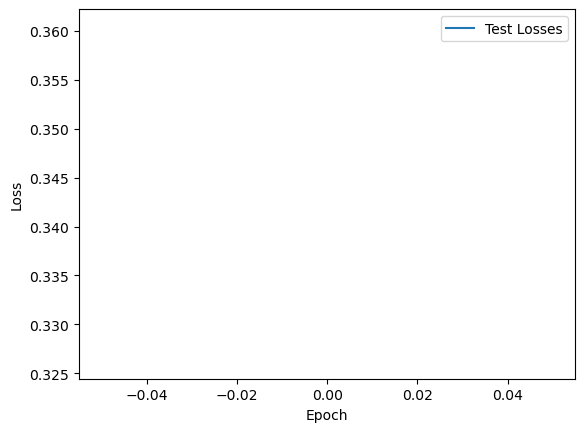

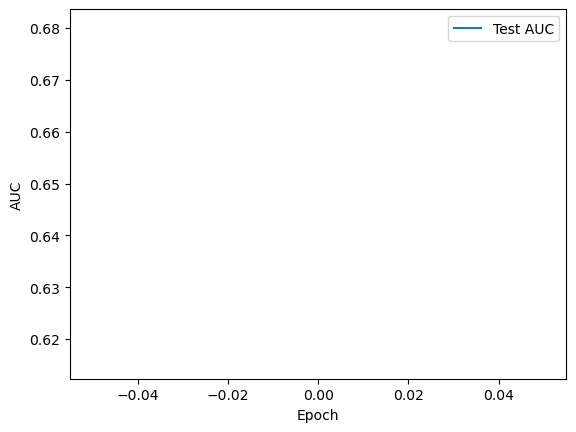

In [6]:
test_dataset = OutfitDataset(data_dir, polyvore_split, split_test, transform)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=default_batch_size,
    shuffle=True,
    collate_fn=custom_collate,
)

total_test_num_outfits = len(test_dataloader.dataset)
print(f"total_test_num_outfits: {total_test_num_outfits}")

test_losses = []  # to store validation losses
test_auc_scores = []  # to store AUC scores
test(
    epoch=0, 
    dataloader=test_dataloader, 
    losses=test_losses, 
    auc_scores=test_auc_scores
)
show_plots(plots=[{"values": test_losses, "label": "Test Losses"}], label="Loss")
show_plots(plots=[{"values": test_auc_scores, "label": "Test AUC"}], label="AUC")